In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
import pycountry
from transformers import pipeline
from tqdm.auto import tqdm
import torch

%matplotlib inline

In [ ]:
# 데이터 불러오기
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./submission.csv')

In [2]:
col = [
    'lead_owner', #영업 담당자 이름
    'expected_timeline', #고객의 요청한 처리 일정
    'is_converted',
]

In [3]:
df_train = df_train[col]
df_test = df_test[col]

In [4]:
# True로 예측된 개수
num_true = sum(df_train['is_converted'] == 1)
print(f'Number of Total Train length: {len(df_train)}')
print(f"Number of True: {num_true}")
print(f'Number of Total Test length: {len(df_test)}')

Number of Total Train length: 59299
Number of True: 4850
Number of Total Test length: 5271


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   lead_owner         59299 non-null  int64 
 1   expected_timeline  28436 non-null  object
 2   is_converted       59299 non-null  bool  
dtypes: bool(1), int64(1), object(1)
memory usage: 984.6+ KB


In [6]:
df_train['lead_owner'] = df_train['lead_owner'].astype(str)
df_test['lead_owner'] = df_test['lead_owner'].astype(str)

In [7]:
def plot_conversion_rate_by_column(df, column_name, top_n=None):
    # column_name 별로 is_converted의 True와 False의 개수를 집계합니다.
    conversion_counts = df.groupby(column_name)['is_converted'].value_counts().unstack(fill_value=0)
    # True 값의 비율을 계산합니다.
    conversion_rate = conversion_counts[True] / conversion_counts.sum(axis=1)
    
    # 비율을 DataFrame으로 만듭니다.
    conversion_rate_df = conversion_rate.sort_values(ascending=False).reset_index(name='Conversion Rate')
    
    # top_n이 지정된 경우, 상위 top_n개의 카테고리만 선택합니다.
    if top_n is not None:
        conversion_rate_df = conversion_rate_df.head(top_n)
    
    # Seaborn의 barplot을 사용하여 수직 막대 그래프를 그립니다.
    plt.figure(figsize=(10, 30), dpi=300)
    sns.barplot(data=conversion_rate_df, y=column_name, x='Conversion Rate', palette="viridis")
    
    # 그래프의 타이틀과 레이블을 설정합니다.
    plt.title(f'Conversion Rate by {column_name}')
    plt.xlabel('Conversion Rate')
    plt.ylabel(column_name)
    
    # 그래프를 보여줍니다.
    plt.show()

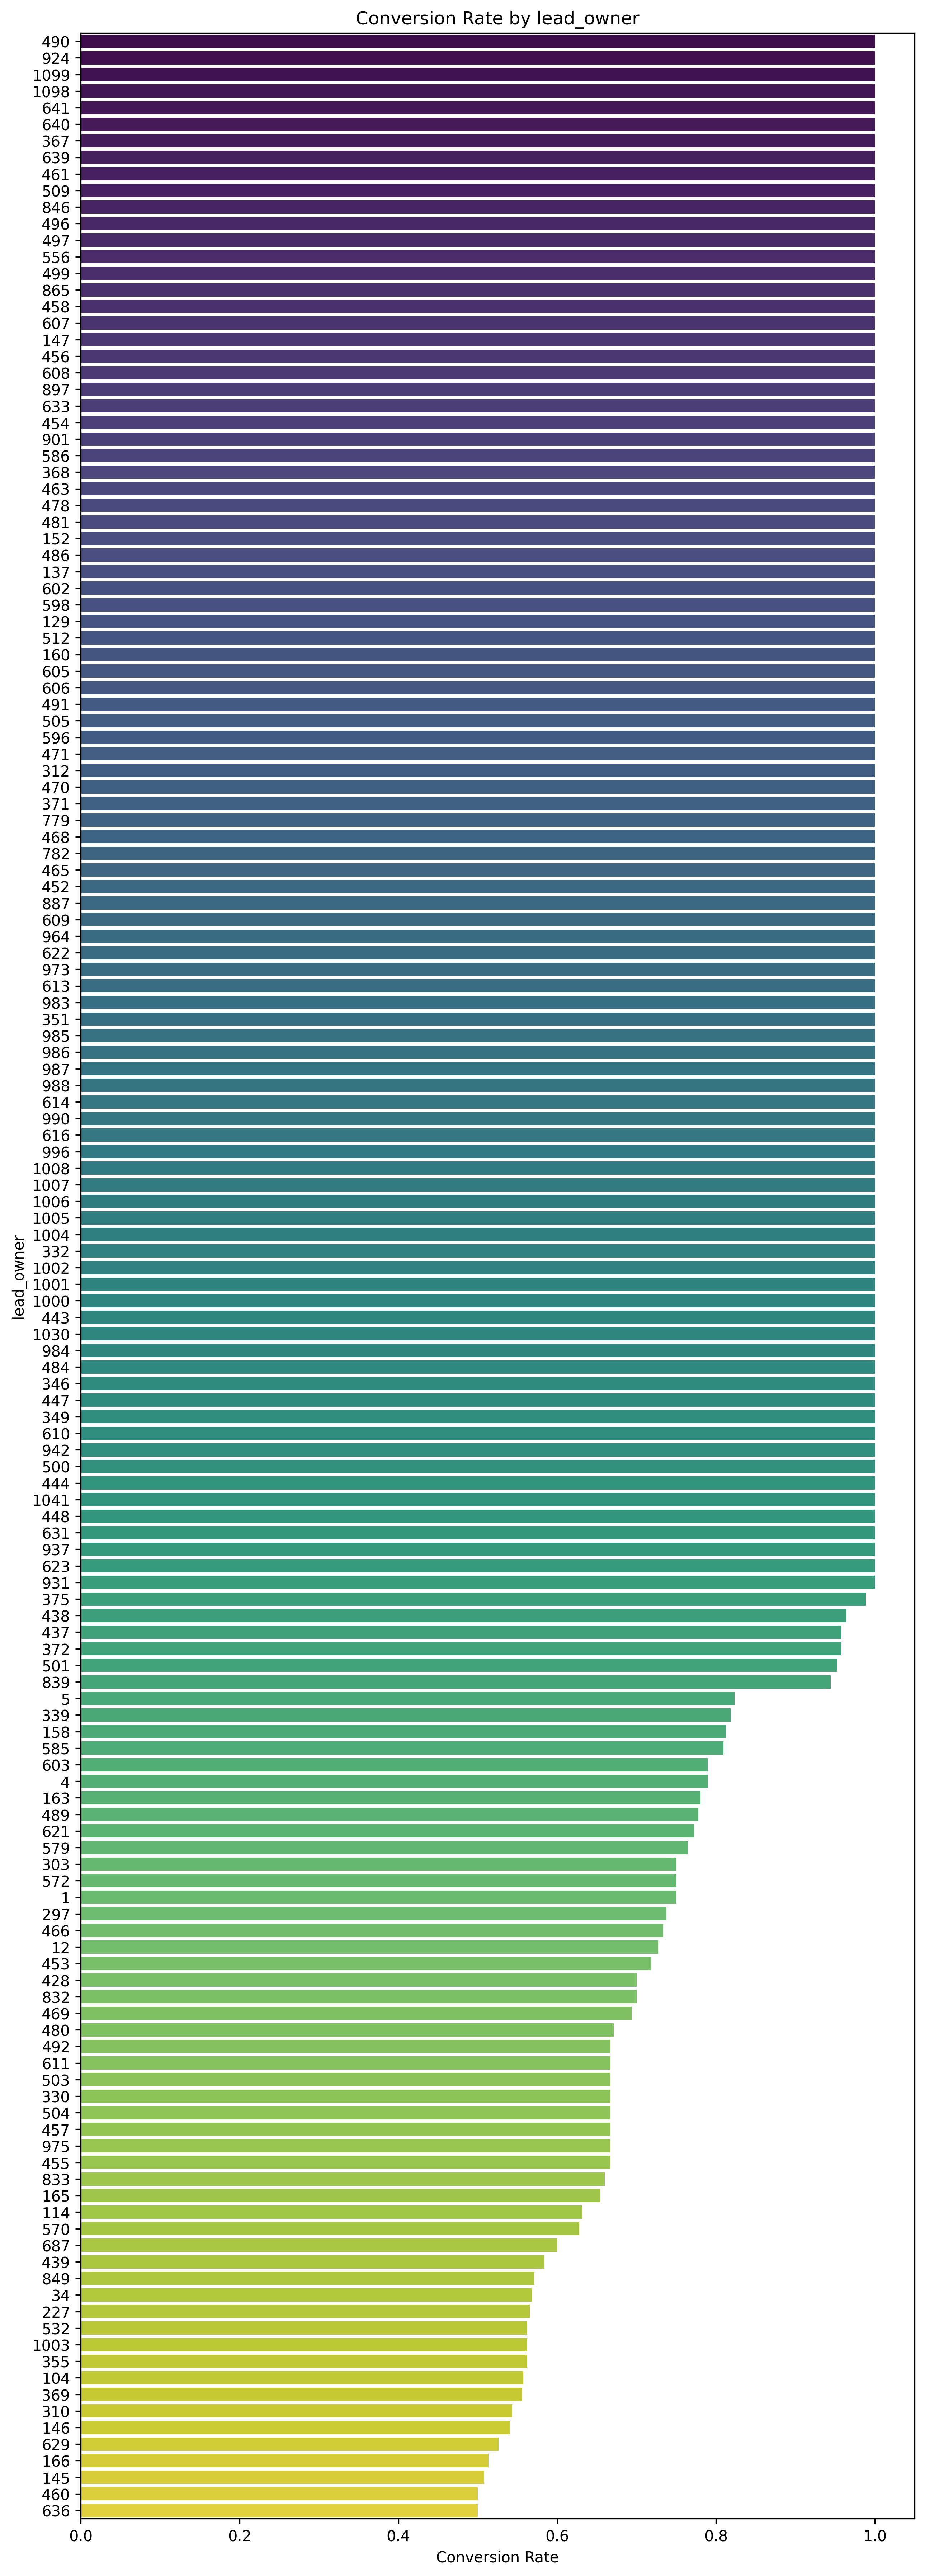

In [8]:
# 함수를 호출하여 그래프를 그립니다. 상위 20개의 카테고리만 표시합니다.
plot_conversion_rate_by_column(df_train, 'lead_owner', top_n=150)

# expected_timeline

In [9]:
print(df_train['expected_timeline'].unique())
print(df_test['expected_timeline'].unique())

['less than 3 months' nan '3 months ~ 6 months' '9 months ~ 1 year'
 'more than a year' '6 months ~ 9 months'
 'quote has been sent to customer.'
 'partner was exploring on eol model for some requiremeent. no designated sales or closure expected hence closing in the system.'
 'already close in july purchse with rd'
 'client not interested in product.. receing call and not answering properly'
 'being followed up' 'being followed up.'
 'repeated inquiry from client. he was just inquiring but have not confimred on purchase. we have tried mulitple times but client is not interested in buying.'
 'update- 7th aug--demo given. customer will confirm next week'
 "tried to reach him multipe times from last 7 days but couldn't get through"
 'details send' 'discused with ankit in dehli'
 'requires detail for tender. no purchase requirement right now.'
 'partner is into static signages. he need to connect for digital signage but he himself is manufacturer. although a mail initaited for any requirem

In [10]:
timeline_categories = [
    'Immediate (less than 3 months)',  # 즉시 (3개월 미만)
    'Short Term (3 to 6 months)',  # 단기 (3개월 ~ 6개월)
    'Medium Term (6 to 9 months)',  # 중기 (6개월 ~ 9개월)
    'Long Term (9 months to 1 year)',  # 장기 (9개월 ~ 1년)
    'Very Long Term (more than a year)',  # 매우 장기 (1년 이상)
    'Not Specified',  # 명시되지 않음
    'Other'  # 기타 (특정 상황이나 상태를 설명하는 경우)
]

In [13]:
# CUDA 사용 가능 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

# Zero-shot classification 파이프라인 초기화
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0 if device == 'cuda' else -1)

# 텍스트 데이터 예시
texts_train = df_train['expected_timeline']#.fillna("Unknown").tolist()  # 결측치 처리
texts_test = df_test['expected_timeline']#.fillna("Unknown").tolist()  # 결측치 처리

Using cuda device


In [14]:
# 텍스트 데이터셋의 의도 분류 함수 (결측치 처리 포함)
def classify_intents(texts, classifier, categories):
    # 결측치가 아닌 데이터만 필터링
    non_missing_texts = texts.dropna().reset_index(drop=True)
    
    # 결측치가 아닌 데이터에 대해 분류 실행
    classified_intents = []
    for text in tqdm(non_missing_texts, desc="Classifying intents"):
        result = classifier(text, categories, multi_label=False)
        classified_intents.append(result['labels'][0])
    
    # 원본 데이터의 인덱스를 유지하기 위해 전체 결과 리스트를 재구성
    final_intents = []
    classified_index = 0  # 분류된 데이터의 인덱스 추적
    for original_index in range(len(texts)):
        if pd.isna(texts.iloc[original_index]) or texts.iloc[original_index].strip() == "":
            final_intents.append("Not Specified")
        else:
            final_intents.append(classified_intents[classified_index])
            classified_index += 1
            
    return final_intents

In [16]:
# 훈련 데이터셋에 대한 의도 분류 (병렬 처리)
intents_train = classify_intents(texts_train, classifier, timeline_categories)
# 테스트 데이터셋에 대한 의도 분류 (병렬 처리)
intents_test = classify_intents(texts_test, classifier, timeline_categories)

Classifying intents:   0%|          | 0/28436 [00:00<?, ?it/s]

/home/baekkwsl/anaconda3/envs/py11/lib/python3.11/site-packages/transformers/pipelines/base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Classifying intents:   0%|          | 0/2863 [00:00<?, ?it/s]

In [17]:
df_train['expected_timeline'] = intents_train
df_test['expected_timeline'] = intents_test

In [7]:
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   lead_owner         59299 non-null  object
 1   expected_timeline  28436 non-null  object
 2   is_converted       59299 non-null  bool  
dtypes: bool(1), object(2)
memory usage: 984.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 0 to 5270
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   lead_owner         5271 non-null   object
 1   expected_timeline  2863 non-null   object
 2   is_converted       5271 non-null   bool  
dtypes: bool(1), object(2)
memory usage: 87.6+ KB
None


In [18]:
SAI_df_train = df_train.drop('is_converted', axis = 1)
SAI_df_test = df_test.drop('is_converted', axis = 1)

SAI_df_train.to_csv('./preprocessing_data/SAI(영업활동정보)_train.csv')
SAI_df_test.to_csv('./preprocessing_data/SAI(영업활동정보)_test.csv')

In [3]:
df_train = pd.read_csv('./preprocessing_data/SAI(영업활동정보)_train.csv')
target_train = pd.read_csv('./preprocessing_data/target_train.csv')
df_train = pd.merge(df_train, target_train, on='Unnamed: 0', how='left')
df_train = df_train.drop('Unnamed: 0', axis = 1)

df_test = pd.read_csv('./preprocessing_data/SAI(영업활동정보)_test.csv')
target_test = pd.read_csv('./preprocessing_data/target_test.csv')
df_test = pd.merge(df_test, target_test, on='Unnamed: 0', how='left')
df_test = df_test.drop('Unnamed: 0', axis = 1)

In [4]:
df_train

,lead_owner,expected_timeline,is_converted
0,0,less than 3 months,True
1,1,less than 3 months,True
2,2,less than 3 months,True
3,3,less than 3 months,True
4,4,less than 3 months,True
...,...,...,...
59294,694,3 months ~ 6 months,False
59295,39,9 months ~ 1 year,False
59296,125,less than 3 months,False
59297,134,more than a year,False


In [11]:
from pycaret.classification import *
clf = setup(data=df_train, 
            target='is_converted', 
            session_id=123, 
            use_gpu=True, 
            #normalize=True,  # 데이터 정규화
            #normalize_method='minmax',  # 정규화 방법
            #feature_selection=True,  # 특성 선택
            #remove_multicollinearity=True,  # 다중공선성 제거
            #categorical_imputation='lightgbm',  # 범주형 변수 결측치는 최빈값으로 대체
            #imputation_type='iterative',  # 반복적인(imputation) 방식 사용
            #categorical_features = col[:-1],
            verbose=True,
           )

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Description,Value
0,Session id,123
1,Target,is_converted
2,Target type,Binary
3,Original data shape,"(59299, 3)"
4,Transformed data shape,"(59299, 3)"
5,Transformed train set shape,"(41509, 3)"
6,Transformed test set shape,"(17790, 3)"
7,Numeric features,2
8,Rows with missing values,52.0%
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


In [12]:
# 모델 비교
best_model = compare_models(sort='F1', cross_validation=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.9338,0.9356,0.5110,0.6149,0.5580,0.5226,0.5253,0.0150
lr,Logistic Regression,0.9388,0.9356,0.4015,0.7299,0.5174,0.4877,0.5130,0.0300
nb,Naive Bayes,0.9258,0.9040,0.4701,0.5544,0.5085,0.4686,0.4707,0.0120
qda,Quadratic Discriminant Analysis,0.9257,0.9038,0.4704,0.5538,0.5084,0.4685,0.4705,0.0130
lightgbm,Light Gradient Boosting Machine,0.9387,0.9378,0.3832,0.7433,0.5052,0.4761,0.5062,0.1110
rf,Random Forest Classifier,0.9366,0.9190,0.3935,0.7025,0.5035,0.4726,0.4958,0.3210
ridge,Ridge Classifier,0.9394,0.0000,0.3711,0.7689,0.5001,0.4720,0.5080,0.0180
gbc,Gradient Boosting Classifier,0.9390,0.9392,0.3711,0.7628,0.4987,0.4704,0.5055,0.4300
knn,K Neighbors Classifier,0.9318,0.8480,0.4130,0.6263,0.4970,0.4621,0.4740,0.1590
et,Extra Trees Classifier,0.9369,0.9071,0.3785,0.7175,0.4946,0.4644,0.4920,0.2630
